# Corporate Debt Value under Transition Scenario Uncertainty
## By Théo Le Guenedal and Peter Tankov
## See https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4152325

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

def bprice(r,b,K,T):
  # risk-free bond price
  return b/r+np.exp(-r*T)*(K-b/r)

def rate(P,b,K,T):
  # service function  
  if np.isscalar(P):
    return srate(P,b,K,T)
  res = np.zeros(len(P))
  for i in range(len(P)):
    res[i] = srate(P[i],b,K,T)
  return res

def srate(P,b,K,T):
  # compute yield rate from price, notional and coupon
  if(P>=K):
    return float('nan')
  x=b/K
  y = 1.
  fy = bprice(y,b,K,T)
  for i in range(10):
    if(P>=fy):
      break
    x= y
    y=y*2.0
    fy = bprice(y,b,K,T)
  if(i >= 10):
    return float('nan')
  for j in range(30+i):
    fy = bprice((x+y)/2,b,K,T)
    if(fy < P) :
      y = (x+y)/2.
    else:
      x= (x+y)/2.
  return  (x+y)/2.

def proba(t,N,lam,r,alpha,mu,p0):
  # service function: compute some auxiliary coefficients
  pt = np.zeros((len(t),len(lam)))
  lamn = lam/np.max(lam)
  for i in range(len(lam)):
    pt[:,i] = np.exp(-t*lam[i])*np.power(lamn[i],N)*p0[i]
  psum = np.sum(pt,axis=1) 
  for i in range(len(lam)):
    pt[:,i] = pt[:,i]/psum
  at = np.dot(pt,1./(r+alpha*lam-mu))
  lt = np.dot(pt,lam)
  return pt, at, lt

def calc_alpha(alpha,Nspace=100,Amin = -2, Amax = 2):
  # service function : Computes admissible alpha closest to the given one
  dx = (Amax-Amin)/Nspace
  k = int(-np.log(1-alpha)/dx)
  return 1-np.exp(-k*dx) 

def bond_price_lambda(T,K, r, b, mu, sigma, lam, alpha, Ntime=100, Nspace=100,Amin = -2, Amax = 2, alam=0):
  # Computes directly the bond price for fixed lambda
  # Ntime and Nspace: time and space discretization
  # Amin and Amax: space truncation
  # returns x,t,ua,frontD,frontU
  # x is the grid in space
  # t is the grid in time
  # ua is bond price as function of time and space  (American option)
  # frontD is the default (lower) frontier
  # frontU is the restructuring (upper) frontier
  x = np.linspace(Amin,Amax,Nspace+1)
  t = np.linspace(0,T,Ntime+1)
  ua = np.zeros((Ntime+1,Nspace+1))
  #ue = np.zeros((Ntime+1,Nspace+1))
  frontD = np.zeros(Ntime+1)
  frontU = np.zeros(Ntime+1)

  dt = 1.*T/Ntime
  dx = (Amax-Amin)/Nspace
  k = int(-np.log(1.-alpha)/dx)
  alpha = 1-np.exp(-k*dx) 
  Amat = np.zeros((Nspace-1,Nspace-1))
  w = 1+r*dt+sigma*sigma*dt/dx/dx + lam*dt
  p = sigma*sigma/2*dt/dx/dx + (mu-sigma*sigma/2)*dt/2/dx
  q = sigma*sigma/2*dt/dx/dx - (mu-sigma*sigma/2)*dt/2/dx
  for i in range(Nspace-2):
    Amat[i,i] = w
    Amat[i,i+1] = -p
    Amat[i+1,i] = -q
  Amat[-1,-1] = w
  for i in range(Nspace-k-1):
    Amat[i+k,i] = -lam*dt
  Ainv_inf = np.linalg.inv(Amat)
  v = np.ones(len(x)-2)*b*dt
  if alam==0:
    alam = 1./(r+alpha*lam-mu)
  ua[Ntime,:] = np.minimum(K,alam*np.exp(x))
  #ue[Ntime,:] = (alam*np.exp(x)-K)*(alam*np.exp(x)>K)

  for i in range(Ntime,0,-1):
    ucond =  K+(r*K-b)*(r*K>b)*(1.-np.exp(-r*(T-t[i-1])))/r
    v[-1] = b*dt+p*ucond 
    ua[i-1,1:-1] = np.dot(Ainv_inf,ua[i,1:-1]+v)
    ua[i-1,0] = K
    ua[i-1,Nspace] = ucond 
    ua[i-1,:] = np.minimum(ua[i-1,:],ua[Ntime,:])
    frontD[i-1] = frontierD(x,ua[i-1,:]-np.minimum(alam*np.exp(x),K),b,K/alam)
    frontU[i-1] = frontierU(x,ua[i-1,:]-np.minimum(alam*np.exp(x),K),K/alam)

  return x,t,ua,frontD,frontU


def frontierD(x,u,b,Ktil):
  # service function: computes the lower (default) frontier for given time
  xmax = np.argwhere(np.exp(x)<=np.minimum(b,Ktil))[-1][0]
  res = np.argwhere(u[:xmax]==0)
  if(len(res))==0:
    return 0
  ifront = res[-1][0]
  a1 = x[ifront+1]
  a2 = x[ifront+2]
  b1 = u[ifront+1]
  b2 = u[ifront+2]
  if(b2==b1):
    return float("NaN")
  front = (a1*b2-b1*a2)/(b2-b1)#2-point interpolation
  return front

def frontierU(x,u,Ktil):
  # service function: computes the upper (restructuring) frontier for given time
  xmax = np.argwhere(np.exp(x)>=Ktil)[0][0]
  res = np.argwhere(u[xmax:]==0)
  if(len(res))==0:
    return float("Inf")
  ifront = res[0][0]+xmax
  if ifront==len(x)-1:
    return float("Inf")
  a1 = x[ifront-2]
  a2 = x[ifront-1]
  b1 = u[ifront-2]
  b2 = u[ifront-1]
  if(b2==b1):
    return float("NaN")
  front = (a1*b2-b1*a2)/(b2-b1)#2-point interpolation
  return front

def bond_price(T,K, r, b, mu, sigma, lam, alp, Nstep = 10, Ntime=100, Nspace=100,Amin = -2, Amax = 2):
  # Main function: Computes firm value by making Nstep iterations over N
  # Ntime and Nspace: time and space discretization
  # Amin and Amax: space truncation
  # returns x,t,umin,umax,frontminD,frontminU,frontmaxD,frontmaxU, uminsave, umaxsave,atsave
  # x is the grid in space
  # t is the grid in time
  # umin and umax are lower and upper bounds of the firm value at the final iteration
  # frontminD,frontminU,frontmaxD,frontmaxU are the exercise / default frontiers 
  # computed from lower/upper bound for the value function as function of time and step size
  # uminsave/umaxsave are the firm values (lower and upper bounds) as function of time, N and space 
  # atsave contains alpha^N(t) as function of N and time
  uminsave = np.zeros((Nstep+1,Ntime+1,Nspace+1))
  umaxsave = np.zeros((Nstep+1,Ntime+1,Nspace+1))
  atsave = np.zeros((Nstep+1,Ntime+1))
  umin = np.zeros((Ntime+1,Nspace+1))
  umax = np.zeros((Ntime+1,Nspace+1))
  frontminU = np.zeros((Nstep+1, Ntime+1))
  frontmaxU = np.zeros((Nstep+1, Ntime+1))
  frontminD = np.zeros((Nstep+1, Ntime+1))
  frontmaxD = np.zeros((Nstep+1, Ntime+1))

  x = np.linspace(Amin,Amax,Nspace+1)
  t = np.linspace(0,T,Ntime+1)
  dt = 1.*T/Ntime
  dx = (Amax-Amin)/Nspace
  k = int(-np.log(1-alp)/dx)
  alpha = 1-np.exp(-k*dx) 
  print(k,alpha)
  # Initialization
  pt, at, lt = proba(t,Nstep,lam,r,alpha,mu,p0)
  alam_min = 1./(r+alpha*np.max(lam)-mu)
  for i in range(len(lam)):
    x,t,ua,frontD,frontU = bond_price_lambda(T,K, r, b, mu, sigma, lam[i], alp, Ntime, Nspace,Amin, Amax,alam_min)
    for j in range(Ntime+1):
      umin[j,:] = umin[j,:] + pt[j,i]*ua[j,:]
  x,t,umax,frontD,frontU = bond_price_lambda(T,K, r, b, mu, sigma, np.min(lam), alp, Ntime, Nspace,Amin, Amax)
    

# Computing the exercise frontier
  for i in range(Ntime,0,-1):
    frontminD[0,i-1] = frontierD(x,umin[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),b,K/at[i-1])
    frontmaxD[0,i-1] = frontierD(x,umax[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),b,K/at[i-1])
    frontminU[0,i-1] = frontierU(x,umin[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),K/at[i-1])
    frontmaxU[0,i-1] = frontierU(x,umax[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),K/at[i-1])
  uminsave[0,:,:] = umin[:,:]
  umaxsave[0,:,:] = umax[:,:]
  atsave[0,:] = at

# Iteration over N
  for n in range(Nstep):
    print('.',end='')
    pt, at, lt = proba(t,Nstep-1-n,lam,r,alpha,mu,p0)
    umin[Ntime,:] = np.minimum(at[Ntime]*np.exp(x),K)
    umax[Ntime,:] = np.minimum(at[Ntime]*np.exp(x),K)
    for i in range(Ntime,0,-1):
      Amat = np.zeros((Nspace-1,Nspace-1))
      w = 1+r*dt+sigma*sigma*dt/dx/dx + dt*lt[i-1]
      p = sigma*sigma/2*dt/dx/dx + (mu-sigma*sigma/2)*dt/2/dx
      q = sigma*sigma/2*dt/dx/dx - (mu-sigma*sigma/2)*dt/2/dx
      for j in range(Nspace-2):
        Amat[j,j] = w
        Amat[j,j+1] = -p
        Amat[j+1,j] = -q
      Amat[-1,-1] = w
      Ainv = np.linalg.inv(Amat)
      vmax = np.ones(len(x)-2)*b*dt 
      vmax[k:] = vmax[k:]+lt[i-1]*umax[i-1,1:-k-1]*dt
      ucond = K+(r*K-b)*(r*K>b)*(1.-np.exp(-r*(T-t[i-1])))/r
      vmax[-1] = vmax[-1]+p*ucond
      umax[i-1,1:-1] = np.dot(Ainv,umax[i,1:-1]+vmax)
      umax[i-1,0] = 0
      umax[i-1,Nspace] = ucond
      umax[i-1,:] = np.minimum(umax[i-1,:],np.minimum(at[i-1]*np.exp(x),K))
      frontmaxD[n+1,i-1] = frontierD(x,umax[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),b,K/at[i-1])
      frontmaxU[n+1,i-1] = frontierU(x,umax[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),K/at[i-1])

      vmin = np.ones(len(x)-2)*b*dt 
      vmin[k:] = vmin[k:]+lt[i-1]*umin[i-1,1:-k-1]*dt
      vmin[-1] = vmin[-1]+p*ucond
      umin[i-1,1:-1] = np.dot(Ainv,umin[i,1:-1]+vmin)
      umin[i-1,0] = 0
      umin[i-1,Nspace] = ucond
      umin[i-1,:] = np.minimum(umin[i-1,:],np.minimum(at[i-1]*np.exp(x),K))
      frontminD[n+1,i-1] = frontierD(x,umin[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),b,K/at[i-1])
      frontminU[n+1,i-1] = frontierU(x,umin[i-1,:]-np.minimum(at[i-1]*np.exp(x),K),K/at[i-1])
    umaxsave[n+1,:,:] = umax[:,:]
    uminsave[n+1,:,:] = umin[:,:]
    atsave[n+1,:] = at
  return x,t,umin,umax,frontminD,frontminU,frontmaxD,frontmaxU, uminsave, umaxsave,atsave

def simtraj(V0,b,K,r,mu,sigma,lam,alpha,x,t,Nstep,frontD,frontU,usave):
    # simulate a trajectory of firm's revenues V, carbon price adjustments N, frontiers fU and fD, bond value and spread
    # Input values:
    # V0: initial revenue value
    # b: coupon
    # K: notional
    # r: risk-free rate
    # mu: growth rate of revenues
    # sigma : volatility of revenues
    # lam : intensity for simulating firm's revenues
    # alpha : carbon price sensitivity
    # x, t, Nstep, frontD, frontU, usave: values returned by function bond_price
    T = t[-1]
    Ntime = len(t)-1
    h = t[1] - t[0]
    jumps = np.random.poisson(lam*h,size=Ntime)
    dV = sigma*np.sqrt(h)*np.random.normal(size=Ntime)+(mu-sigma**2/2)*h + np.log(1-alpha)*jumps
    V = np.zeros(Ntime+1)
    V[1:] = np.cumsum(dV)
    V = V0*np.exp(V)
    N = np.zeros(Ntime+1,dtype=np.int_)
    N[1:] = np.cumsum(jumps)
    fU = np.zeros(Ntime+1)
    fD = np.zeros(Ntime+1)
    val = np.zeros(Ntime+1)
    spread = np.zeros(Ntime+1)
    for i in range(Ntime+1):
        fU[i] = frontU[Nstep-N[i],i]
        fD[i] = frontD[Nstep-N[i],i]
        val[i] = np.interp(V[i],np.exp(x),usave[Nstep-N[i],i,:])
        spread[i] = rate(val[i],b,K,T-t[i])-r
    return V,N,fU,fD,val,spread
    
    
    
    

In [21]:
# Testing the function bond_price
T = 5.
r = 0.04
b = 1.5
mu = 0.04
sigma = 0.3
#lam = np.array([1,2,3])
lam =np.array([0.101,0.634,2.234])
p0 = np.array([0.334,0.333,0.333])
Amax = 3.
Amin = -4.
Nspace = 700
Ntime = 300
t = np.linspace(0,T,Ntime+1)
alpha = 0.02
Nstep = 40
K = 30

x,t,umin,umax,frontminD,frontminU,frontmaxD,frontmaxU, uminsave, umaxsave,atsave = bond_price(T,K, r, b, mu, sigma, lam, alpha, Nstep, Ntime, Nspace,Amin, Amax)
x,t,ua0,front0D,front0U = bond_price_lambda(T,K, r, b, mu, sigma, lam[0], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua1,front1D,front1U = bond_price_lambda(T,K, r, b, mu, sigma, lam[1], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua2,front2D,front2U = bond_price_lambda(T,K, r, b, mu, sigma, lam[2], alpha,  Ntime, Nspace,Amin, Amax)
sp_min = np.log(np.max(umaxsave[:,0,:]-uminsave[:,0,:],axis=1))/np.log(10)


2 0.019801326693244747
........................................

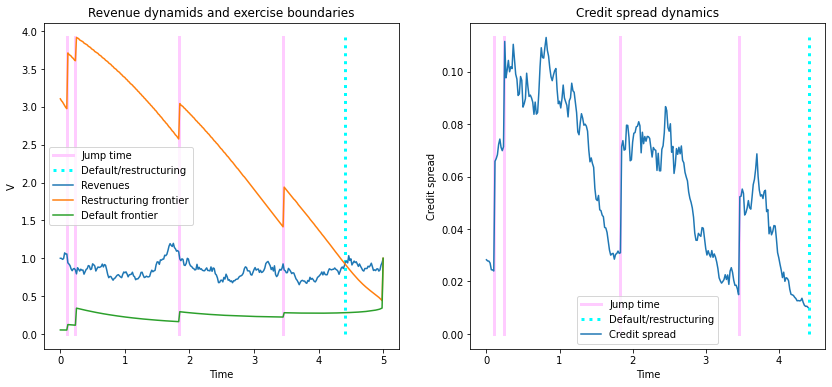

In [159]:
# Plotting trajectories
V0 = 1.
V,N,fU,fD,val,spread = simtraj(V0,b,K,r,mu,sigma,lam[1],alpha,x,t,Nstep,frontmaxD,frontmaxU,umaxsave)
maxind1= np.where(V>np.exp(fU))[0]
if len(maxind1)==0:
    maxind1 = len(t)-1
else:
    maxind1 = maxind1[0]
maxind2= np.where(V<np.exp(fD))[0]
if len(maxind2)==0:
    maxind2 = len(t)-1
else:
    maxind2 = maxind2[0]
maxind = np.minimum(maxind1,maxind2)
jind= np.where(np.diff(N)==1)[0]
jtimes= t[jind]
plt.figure(figsize=(14,6))
plt.subplot(121)
if len(jtimes)>0:
    plt.plot([jtimes[0],jtimes[0]],[0,np.max(np.exp(fU))],linewidth=3,color=(1.0,.8,1.0),label='Jump time')
for i in range(1,len(jtimes)):
    plt.plot([jtimes[i],jtimes[i]],[0,np.max(np.exp(fU))],linewidth=3,color=(1.0,.8,1.0))
if(maxind < len(t)-1):
    plt.plot([t[maxind],t[maxind]],[0,np.max(np.exp(fU))],':',linewidth=3,color=(.0,1.0,1.0),label='Default/restructuring')
plt.plot(t,V,label='Revenues')
plt.plot(t,np.exp(fU),label='Restructuring frontier')
plt.plot(t,np.exp(fD),label='Default frontier')
plt.legend()
plt.title('Revenue dynamids and exercise boundaries')
plt.xlabel('Time')
plt.ylabel('V')
plt.subplot(122)

if len(jtimes)>0:
    if jind[0]<maxind:
        plt.plot([jtimes[0],jtimes[0]],[0,np.max(spread[:maxind])],linewidth=3,color=(1.0,.8,1.0),label='Jump time')
for i in range(1,len(jtimes)):
    if jind[i]<maxind:
        plt.plot([jtimes[i],jtimes[i]],[0,np.max(spread[:maxind])],linewidth=3,color=(1.0,.8,1.0))
if(maxind < len(t)-1):
    plt.plot([t[maxind],t[maxind]],[0,np.max(spread[:maxind])],':',linewidth=3,color=(.0,1.0,1.0),label='Default/restructuring')
plt.plot(t[:maxind],spread[:maxind],label='Credit spread')
plt.title('Credit spread dynamics')
plt.ylabel('Credit spread')
plt.xlabel('Time')
plt.legend()
plt.savefig('dyn_almin1.pdf',format='pdf')

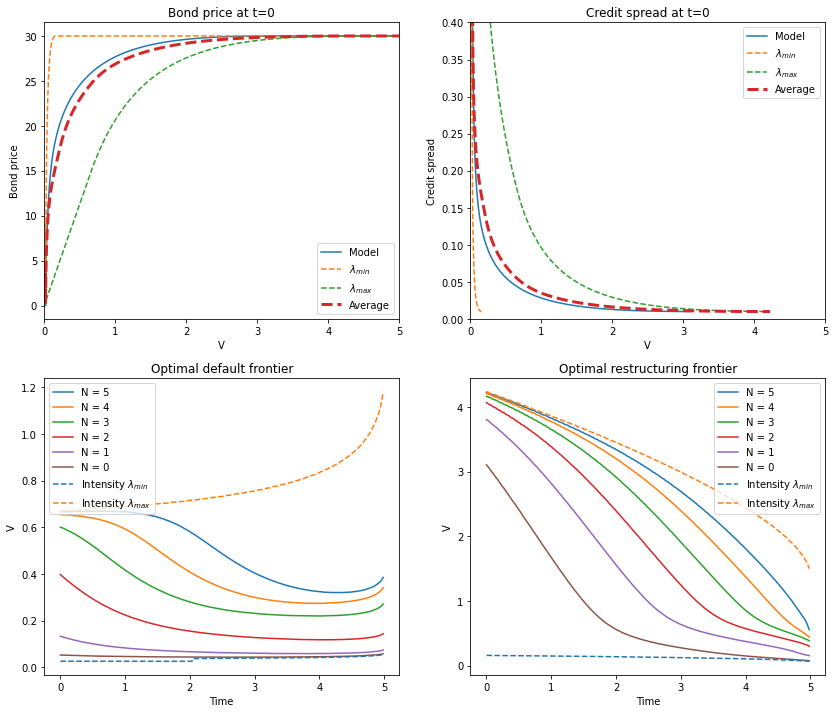

In [161]:
# Plotting prices, spreads and frontiers
minV = .1
plotrange = range(34,Nstep,1)
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.plot(np.exp(x),umaxsave[-1,0,:],label="Model")
plt.plot(np.exp(x),ua0[0,:],'--',label='$\lambda_{min}$')
plt.plot(np.exp(x),ua2[0,:],'--',label='$\lambda_{max}$')
plt.plot(np.exp(x),p0[0]*ua0[0,:]+p0[1]*ua1[0,:]+p0[2]*ua2[0,:],'--',linewidth=3,label='Average')
plt.xlim([0,5])
plt.legend()
plt.xlabel('V')
plt.ylabel('Bond price')
plt.title('Bond price at t=0')

plt.subplot(222)
plt.plot(np.exp(x),rate(umaxsave[-1,0,:],b,K,T)-r,label="Model")
plt.plot(np.exp(x),rate(ua0[0,:],b,K,T)-r,'--',label='$\lambda_{min}$')
plt.plot(np.exp(x),rate(ua2[0,:],b,K,T)-r,'--',label='$\lambda_{max}$')
plt.plot(np.exp(x),rate(p0[0]*ua0[0,:]+p0[1]*ua1[0,:]+p0[2]*ua2[0,:],b,K,T)-r,'--',linewidth=3,label='Average')

plt.xlim([0,5])
plt.ylim([0,0.4])
plt.legend()
plt.xlabel('V')
plt.ylabel('Credit spread')
plt.title('Credit spread at t=0')
plt.subplot(223)
plt.title('Optimal default frontier')
for c,i in enumerate(plotrange):
  plt.plot(t[:-1],np.exp(frontmaxD[i+1,:-1]),label="N = "+str(Nstep-i-1),color='C'+str(c))
plt.plot(t[:-1],np.exp(front0D[:-1]),'--',label='Intensity $\lambda_{min}$')
plt.plot(t[:-1],np.exp(front2D[:-1]),'--',label='Intensity $\lambda_{max}$')
plt.xlabel('Time')
plt.ylabel('V')
plt.legend(loc=2)

plt.subplot(224)
plt.title('Optimal restructuring frontier')
for c,i in enumerate(plotrange):
  plt.plot(t[:-1],np.exp(frontmaxU[i+1,:-1]),label="N = "+str(Nstep-i-1),color='C'+str(c))
plt.plot(t[:-1],np.exp(front0U[:-1]),'--',label='Intensity $\lambda_{min}$')
plt.plot(t[:-1],np.exp(front2U[:-1]),'--',label='Intensity $\lambda_{max}$')
plt.xlabel('Time')
plt.ylabel('V')
plt.legend(loc=1)
plt.savefig('value_almin2.pdf',format='pdf')

In [162]:
# Testing the function bond_price
T = 5.
r = 0.04
b = 1.5
mu = 0.04
sigma = 0.3
#lam = np.array([1,2,3])
lam =np.array([0.101,0.634,2.234])
p0 = np.array([0.334,0.333,0.333])
Amax = 3.
Amin = -4.
Nspace = 700
Ntime = 300
t = np.linspace(0,T,Ntime+1)
alpha = 0.05
Nstep = 40
K = 30

x,t,umin,umax,frontminD,frontminU,frontmaxD,frontmaxU, uminsave, umaxsave,atsave = bond_price(T,K, r, b, mu, sigma, lam, alpha, Nstep, Ntime, Nspace,Amin, Amax)
x,t,ua0,front0D,front0U = bond_price_lambda(T,K, r, b, mu, sigma, lam[0], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua1,front1D,front1U = bond_price_lambda(T,K, r, b, mu, sigma, lam[1], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua2,front2D,front2U = bond_price_lambda(T,K, r, b, mu, sigma, lam[2], alpha,  Ntime, Nspace,Amin, Amax)
sp_med = np.log(np.max(umaxsave[:,0,:]-uminsave[:,0,:],axis=1))/np.log(10)


5 0.048770575499285984
........................................

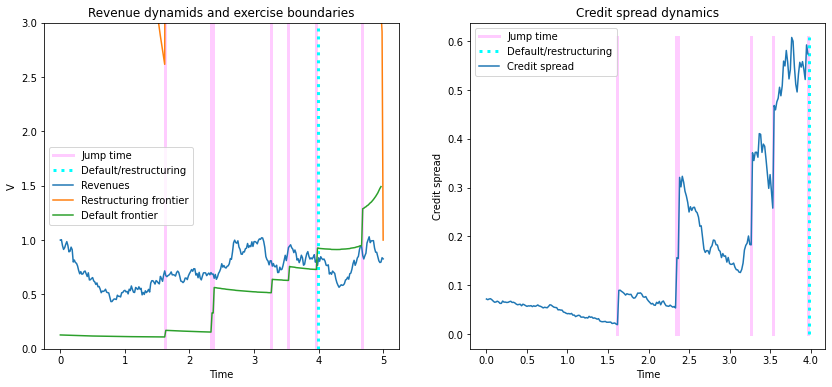

In [193]:
# Plotting trajectories
V0 = 1.
V,N,fU,fD,val,spread = simtraj(V0,b,K,r,mu,sigma,lam[1],alpha,x,t,Nstep,frontmaxD,frontmaxU,umaxsave)
maxind1= np.where(V>np.exp(fU))[0]
if len(maxind1)==0:
    maxind1 = len(t)-1
else:
    maxind1 = maxind1[0]
maxind2= np.where(V<np.exp(fD))[0]
if len(maxind2)==0:
    maxind2 = len(t)-1
else:
    maxind2 = maxind2[0]
maxind = np.minimum(maxind1,maxind2)
jind= np.where(np.diff(N)==1)[0]
jtimes= t[jind]
plt.figure(figsize=(14,6))
plt.subplot(121)
if len(jtimes)>0:
    plt.plot([jtimes[0],jtimes[0]],[0,np.max(np.exp(fU))],linewidth=3,color=(1.0,.8,1.0),label='Jump time')
for i in range(1,len(jtimes)):
    plt.plot([jtimes[i],jtimes[i]],[0,np.max(np.exp(fU))],linewidth=3,color=(1.0,.8,1.0))
if(maxind < len(t)-1):
    plt.plot([t[maxind],t[maxind]],[0,np.max(np.exp(fU))],':',linewidth=3,color=(.0,1.0,1.0),label='Default/restructuring')
plt.plot(t,V,label='Revenues')
plt.plot(t,np.exp(fU),label='Restructuring frontier')
plt.plot(t,np.exp(fD),label='Default frontier')
plt.legend()
plt.title('Revenue dynamids and exercise boundaries')
plt.xlabel('Time')
plt.ylabel('V')
plt.ylim([0,3])
plt.subplot(122)

if len(jtimes)>0:
    if jind[0]<maxind:
        plt.plot([jtimes[0],jtimes[0]],[0,np.max(spread[:maxind])],linewidth=3,color=(1.0,.8,1.0),label='Jump time')
for i in range(1,len(jtimes)):
    if jind[i]<maxind:
        plt.plot([jtimes[i],jtimes[i]],[0,np.max(spread[:maxind])],linewidth=3,color=(1.0,.8,1.0))
if(maxind < len(t)-1):
    plt.plot([t[maxind],t[maxind]],[0,np.max(spread[:maxind])],':',linewidth=3,color=(.0,1.0,1.0),label='Default/restructuring')
plt.plot(t[:maxind],spread[:maxind],label='Credit spread')
plt.title('Credit spread dynamics')
plt.ylabel('Credit spread')
plt.xlabel('Time')
plt.legend()
plt.savefig('dyn_almed2.pdf',format='pdf')

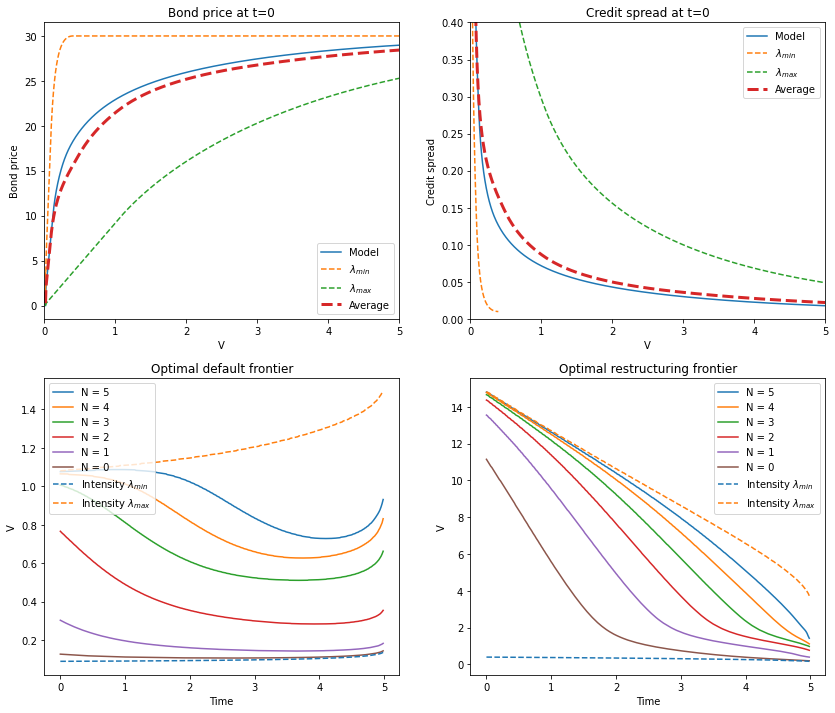

In [195]:
# Plotting prices, spreads and frontiers
minV = .1
plotrange = range(34,Nstep,1)
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.plot(np.exp(x),umaxsave[-1,0,:],label="Model")
plt.plot(np.exp(x),ua0[0,:],'--',label='$\lambda_{min}$')
plt.plot(np.exp(x),ua2[0,:],'--',label='$\lambda_{max}$')
plt.plot(np.exp(x),p0[0]*ua0[0,:]+p0[1]*ua1[0,:]+p0[2]*ua2[0,:],'--',linewidth=3,label='Average')
plt.xlim([0,5])
plt.legend()
plt.xlabel('V')
plt.ylabel('Bond price')
plt.title('Bond price at t=0')

plt.subplot(222)
plt.plot(np.exp(x),rate(umaxsave[-1,0,:],b,K,T)-r,label="Model")
plt.plot(np.exp(x),rate(ua0[0,:],b,K,T)-r,'--',label='$\lambda_{min}$')
plt.plot(np.exp(x),rate(ua2[0,:],b,K,T)-r,'--',label='$\lambda_{max}$')
plt.plot(np.exp(x),rate(p0[0]*ua0[0,:]+p0[1]*ua1[0,:]+p0[2]*ua2[0,:],b,K,T)-r,'--',linewidth=3,label='Average')

plt.xlim([0,5])
plt.ylim([0,0.4])
plt.legend()
plt.xlabel('V')
plt.ylabel('Credit spread')
plt.title('Credit spread at t=0')
plt.subplot(223)
plt.title('Optimal default frontier')
for c,i in enumerate(plotrange):
  plt.plot(t[:-1],np.exp(frontmaxD[i+1,:-1]),label="N = "+str(Nstep-i-1),color='C'+str(c))
plt.plot(t[:-1],np.exp(front0D[:-1]),'--',label='Intensity $\lambda_{min}$')
plt.plot(t[:-1],np.exp(front2D[:-1]),'--',label='Intensity $\lambda_{max}$')
plt.xlabel('Time')
plt.ylabel('V')
plt.legend(loc=2)

plt.subplot(224)
plt.title('Optimal restructuring frontier')
for c,i in enumerate(plotrange):
  plt.plot(t[:-1],np.exp(frontmaxU[i+1,:-1]),label="N = "+str(Nstep-i-1),color='C'+str(c))
plt.plot(t[:-1],np.exp(front0U[:-1]),'--',label='Intensity $\lambda_{min}$')
plt.plot(t[:-1],np.exp(front2U[:-1]),'--',label='Intensity $\lambda_{max}$')
plt.xlabel('Time')
plt.ylabel('V')
plt.legend(loc=1)
plt.savefig('value_almed2.pdf',format='pdf')

In [196]:
# Testing the function bond_price
T = 5.
r = 0.04
b = 1.5
mu = 0.04
sigma = 0.3
#lam = np.array([1,2,3])
lam =np.array([0.101,0.634,2.234])
p0 = np.array([0.334,0.333,0.333])
Amax = 4.
Amin = -4.
Nspace = 800
Ntime = 300
t = np.linspace(0,T,Ntime+1)
alpha = 0.1
Nstep = 40
K = 30

x,t,umin,umax,frontminD,frontminU,frontmaxD,frontmaxU, uminsave, umaxsave,atsave = bond_price(T,K, r, b, mu, sigma, lam, alpha, Nstep, Ntime, Nspace,Amin, Amax)
x,t,ua0,front0D,front0U = bond_price_lambda(T,K, r, b, mu, sigma, lam[0], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua1,front1D,front1U = bond_price_lambda(T,K, r, b, mu, sigma, lam[1], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua2,front2D,front2U = bond_price_lambda(T,K, r, b, mu, sigma, lam[2], alpha,  Ntime, Nspace,Amin, Amax)
sp_max = np.log(np.max(umaxsave[:,0,:]-uminsave[:,0,:],axis=1))/np.log(10)


10 0.09516258196404048
........................................

In [234]:
# Testing the function bond_price, different carbon price adjustment value Delta C
T = 5.
r = 0.04
b = 1.5
mu = 0.04
sigma = 0.3
#lam = np.array([1,2,3])
lam =0.5*np.array([0.101,0.634,2.234])
p0 = np.array([0.334,0.333,0.333])
Amax = 4.
Amin = -4.
Nspace = 800
Ntime = 300
t = np.linspace(0,T,Ntime+1)
alpha = 0.2
Nstep = 40
K = 30

x,t,umint,umaxt,frontminDt,frontminUt,frontmaxDt,frontmaxUt, uminsavet, umaxsavet,atsavet = bond_price(T,K, r, b, mu, sigma, lam, alpha, Nstep, Ntime, Nspace,Amin, Amax)
x,t,ua0t,front0Dt,front0Ut = bond_price_lambda(T,K, r, b, mu, sigma, lam[0], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua1t,front1Dt,front1Ut = bond_price_lambda(T,K, r, b, mu, sigma, lam[1], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua2t,front2Dt,front2Ut = bond_price_lambda(T,K, r, b, mu, sigma, lam[2], alpha,  Ntime, Nspace,Amin, Amax)

22 0.1974812020375215
........................................

In [236]:
# Testing the function bond_price, different carbon price adjustment value Delta C

T = 5.
r = 0.04
b = 1.5
mu = 0.04
sigma = 0.3
#lam = np.array([1,2,3])
lam =2.*np.array([0.101,0.634,2.234])
p0 = np.array([0.334,0.333,0.333])
Amax = 4.
Amin = -4.
Nspace = 800
Ntime = 300
t = np.linspace(0,T,Ntime+1)
alpha = 0.05
Nstep = 40
K = 30

x,t,umintt,umaxtt,frontminDtt,frontminUtt,frontmaxDtt,frontmaxUtt, uminsavett, umaxsavett,atsavett = bond_price(T,K, r, b, mu, sigma, lam, alpha, Nstep, Ntime, Nspace,Amin, Amax)
x,t,ua0tt,front0Dtt,front0Utt = bond_price_lambda(T,K, r, b, mu, sigma, lam[0], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua1tt,front1Dtt,front1Utt = bond_price_lambda(T,K, r, b, mu, sigma, lam[1], alpha, Ntime, Nspace,Amin, Amax)
x,t,ua2tt,front2Dtt,front2Utt = bond_price_lambda(T,K, r, b, mu, sigma, lam[2], alpha,  Ntime, Nspace,Amin, Amax)

5 0.048770575499285984
........................................

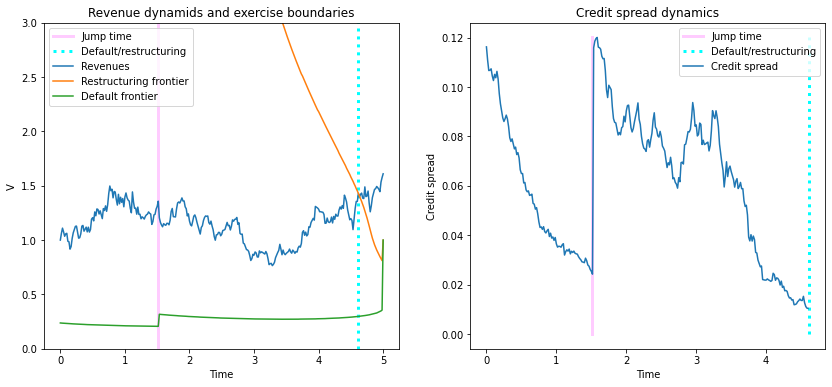

In [232]:
# Plotting trajectories
V0 = 1.
V,N,fU,fD,val,spread = simtraj(V0,b,K,r,mu,sigma,lam[1],alpha,x,t,Nstep,frontmaxD,frontmaxU,umaxsave)
maxind1= np.where(V>np.exp(fU))[0]
if len(maxind1)==0:
    maxind1 = len(t)-1
else:
    maxind1 = maxind1[0]
maxind2= np.where(V<np.exp(fD))[0]
if len(maxind2)==0:
    maxind2 = len(t)-1
else:
    maxind2 = maxind2[0]
maxind = np.minimum(maxind1,maxind2)
jind= np.where(np.diff(N)==1)[0]
jtimes= t[jind]
plt.figure(figsize=(14,6))
plt.subplot(121)
if len(jtimes)>0:
    plt.plot([jtimes[0],jtimes[0]],[0,np.max(np.exp(fU))],linewidth=3,color=(1.0,.8,1.0),label='Jump time')
for i in range(1,len(jtimes)):
    plt.plot([jtimes[i],jtimes[i]],[0,np.max(np.exp(fU))],linewidth=3,color=(1.0,.8,1.0))
if(maxind < len(t)-1):
    plt.plot([t[maxind],t[maxind]],[0,np.max(np.exp(fU))],':',linewidth=3,color=(.0,1.0,1.0),label='Default/restructuring')
plt.plot(t,V,label='Revenues')
plt.plot(t,np.exp(fU),label='Restructuring frontier')
plt.plot(t,np.exp(fD),label='Default frontier')
plt.legend()
plt.title('Revenue dynamids and exercise boundaries')
plt.xlabel('Time')
plt.ylabel('V')
plt.ylim([0,3])
plt.subplot(122)

if len(jtimes)>0:
    if jind[0]<maxind:
        plt.plot([jtimes[0],jtimes[0]],[0,np.max(spread[:maxind])],linewidth=3,color=(1.0,.8,1.0),label='Jump time')
for i in range(1,len(jtimes)):
    if jind[i]<maxind:
        plt.plot([jtimes[i],jtimes[i]],[0,np.max(spread[:maxind])],linewidth=3,color=(1.0,.8,1.0))
if(maxind < len(t)-1):
    plt.plot([t[maxind],t[maxind]],[0,np.max(spread[:maxind])],':',linewidth=3,color=(.0,1.0,1.0),label='Default/restructuring')
plt.plot(t[:maxind],spread[:maxind],label='Credit spread')
plt.title('Credit spread dynamics')
plt.ylabel('Credit spread')
plt.xlabel('Time')
plt.legend()
plt.savefig('dyn_almax2.pdf',format='pdf')

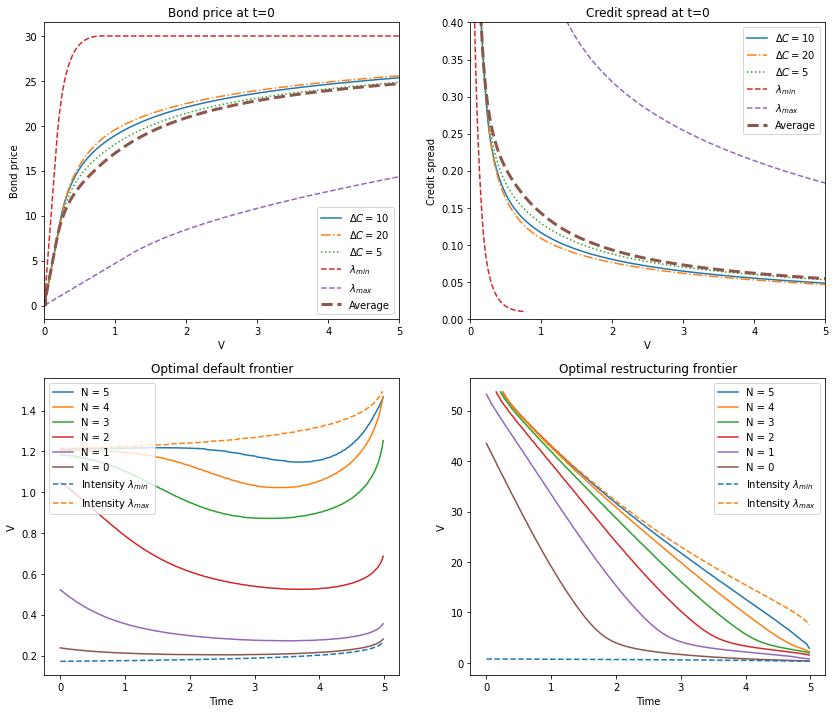

In [242]:
# Plotting prices, spreads and frontiers
minV = .1
plotrange = range(34,Nstep,1)
plt.figure(figsize=(14,12))
plt.subplot(221)
plt.plot(np.exp(x),umaxsave[-1,0,:],label="$\Delta C = 10$")
plt.plot(np.exp(x),umaxsavet[-1,0,:],'-.',label="$\Delta C = 20$")
plt.plot(np.exp(x),umaxsavett[-1,0,:],':',label="$\Delta C = 5$")


plt.plot(np.exp(x),ua0[0,:],'--',label='$\lambda_{min}$')
plt.plot(np.exp(x),ua2[0,:],'--',label='$\lambda_{max}$')
plt.plot(np.exp(x),p0[0]*ua0[0,:]+p0[1]*ua1[0,:]+p0[2]*ua2[0,:],'--',linewidth=3,label='Average')
plt.xlim([0,5])
plt.legend()
plt.xlabel('V')
plt.ylabel('Bond price')
plt.title('Bond price at t=0')

plt.subplot(222)
plt.plot(np.exp(x),rate(umaxsave[-1,0,:],b,K,T)-r,label="$\Delta C = 10$")
plt.plot(np.exp(x),rate(umaxsavet[-1,0,:],b,K,T)-r,'-.',label="$\Delta C = 20$")
plt.plot(np.exp(x),rate(umaxsavett[-1,0,:],b,K,T)-r,':',label="$\Delta C = 5$")

plt.plot(np.exp(x),rate(ua0[0,:],b,K,T)-r,'--',label='$\lambda_{min}$')
plt.plot(np.exp(x),rate(ua2[0,:],b,K,T)-r,'--',label='$\lambda_{max}$')
plt.plot(np.exp(x),rate(p0[0]*ua0[0,:]+p0[1]*ua1[0,:]+p0[2]*ua2[0,:],b,K,T)-r,'--',linewidth=3,label='Average')

plt.xlim([0,5])
plt.ylim([0,0.4])
plt.legend()
plt.xlabel('V')
plt.ylabel('Credit spread')
plt.title('Credit spread at t=0')
plt.subplot(223)
plt.title('Optimal default frontier')
for c,i in enumerate(plotrange):
  plt.plot(t[:-1],np.exp(frontmaxD[i+1,:-1]),label="N = "+str(Nstep-i-1),color='C'+str(c))
plt.plot(t[:-1],np.exp(front0D[:-1]),'--',label='Intensity $\lambda_{min}$')
plt.plot(t[:-1],np.exp(front2D[:-1]),'--',label='Intensity $\lambda_{max}$')
plt.xlabel('Time')
plt.ylabel('V')
plt.legend(loc=2)

plt.subplot(224)
plt.title('Optimal restructuring frontier')
for c,i in enumerate(plotrange):
  plt.plot(t[:-1],np.exp(frontmaxU[i+1,:-1]),label="N = "+str(Nstep-i-1),color='C'+str(c))
plt.plot(t[:-1],np.exp(front0U[:-1]),'--',label='Intensity $\lambda_{min}$')
plt.plot(t[:-1],np.exp(front2U[:-1]),'--',label='Intensity $\lambda_{max}$')
plt.xlabel('Time')
plt.ylabel('V')
plt.legend(loc=1)
plt.savefig('value_almax2.pdf',format='pdf')

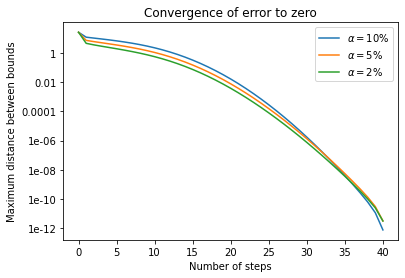

In [143]:
# Testing the convergence of error to zero
plt.plot(range(len(sp_max)),sp_max,label=r'$\alpha=10\%$')
plt.plot(range(len(sp_max)),sp_med,label=r'$\alpha=5\%$')
plt.plot(range(len(sp_max)),sp_min,label=r'$\alpha=2\%$')
plt.yticks([-12, -10,-8,-6,-4,-2,0],[1e-12, 1e-10, 1e-8,1e-6,1e-4,1e-2,1])
plt.legend()
plt.title('Convergence of error to zero')
plt.xlabel('Number of steps')
plt.ylabel('Maximum distance between bounds')
plt.savefig('convergence.pdf',format='pdf')